# Project 1 Benson

### Women Tech Women Yes company wanted a promotion of summit in autumn 2016, they needed a strategy for the street team to optimize the distribution of signups on MTA stations considering audiance would be women in tech. This project analyzed MTA turnstile data with demographics data, and find out the best time and stations for street team to get women in tech and people related to sign up for the event.


MTA stations for women in tech: Pandas | statistics 
<br>
• Found the busiest stations in NYC with statistics data.
<br>
• Revised the popular stations with high tech companies.

In [1]:
from __future__ import print_function, division

In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

## I. Download three-month MTA turnstile data files and create DataFrame

In [13]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [160903, 160910, 160917, 160924]
turnstiles_df = get_data(week_nums)

In [6]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [7]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

In [8]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [23]:
turnstiles_df.head(1)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,Year
0,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,00:00:00,REGULAR,5799442,1966041,2016-08-27,2016


In [24]:
turnstiles_df.tail(1)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,Year
192677,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/23/2016,21:00:00,REGULAR,5554,271,2016-09-23 21:00:00,2016


In [11]:
# Four weeks of Data
turnstiles_df.DATE.value_counts().sort_index()

08/27/2016    27290
08/28/2016    27300
08/29/2016    27828
08/30/2016    27775
08/31/2016    27352
09/01/2016    28116
09/02/2016    27478
09/03/2016    27353
09/04/2016    27304
09/05/2016    27325
09/06/2016    28826
09/07/2016    27977
09/08/2016    28137
09/09/2016    27956
09/10/2016    27325
09/11/2016    27334
09/12/2016    28074
09/13/2016    27343
09/14/2016    27359
09/15/2016    27283
09/16/2016    28160
09/17/2016    27381
09/18/2016    27320
09/19/2016    27551
09/20/2016    27812
09/21/2016    28151
09/22/2016    27221
09/23/2016    27242
Name: DATE, dtype: int64

## II. Find the counts of daily entries in all stations.

In [36]:
def clean_data(rawdata):
    rawdata['STATION-LINE'] = rawdata['STATION']+' '+rawdata['LINENAME']
    rawdata['DATE-TIME'] = pd.to_datetime(rawdata.DATE + ' ' + rawdata.TIME, format = "%m/%d/%Y %H:%M:%S")
    gb_turnstilea = rawdata.groupby(['C/A', 'UNIT','STATION-LINE','DATE'])

    gb_turnstilea_daily = gb_turnstilea.ENTRIES.first().reset_index()

    gb_turnstilea_daily[['PREV_DATE', 'PREV_ENTRIES']] = (gb_turnstilea_daily
                                                    .groupby(['C/A', 'UNIT', 'STATION-LINE'])['DATE', 'ENTRIES']
                                                    .transform(lambda grp: grp.shift(1)))
    
    gb_turnstilea_daily.dropna(subset=['PREV_DATE'], axis=0, inplace=True)
    gb_turnstilea_daily[gb_turnstilea_daily['ENTRIES'] < gb_turnstilea_daily['PREV_ENTRIES']].head(10)
    gb_turnstilea_daily["DAILY_ENTRIES"] = gb_turnstilea_daily.apply(daily_counts, axis=1, max_counter=1000000)

    return gb_turnstilea_daily


def daily_counts(row, max_counter):
    counter = row['ENTRIES'] - row['PREV_ENTRIES']
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row['ENTRIES'], row['PREV_ENTRIES'])
        return 0
    return counter

gb_turnstilea_daily = clean_data(turnstiles_df)
gb_turnstilea_daily.head()

15427664 1298162.0
1217 15427664.0
16828025 75866.0
1315 74672293.0
100663296 1299.0
117440514 100663296.0
3 3655192.0
12532758 5209271.0


,C/A,UNIT,STATION-LINE,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,59 ST NQR456,08/28/2016,5800252,08/27/2016,5799442.0,810.0
2,A002,R051,59 ST NQR456,08/29/2016,5800934,08/28/2016,5800252.0,682.0
3,A002,R051,59 ST NQR456,08/30/2016,5802514,08/29/2016,5800934.0,1580.0
4,A002,R051,59 ST NQR456,08/31/2016,5804071,08/30/2016,5802514.0,1557.0
5,A002,R051,59 ST NQR456,09/01/2016,5805638,08/31/2016,5804071.0,1567.0


In [37]:
def daily_station(cleandata):
    station_daily = gb_turnstilea_daily.sort_values(['STATION-LINE','DATE'])
    station_daily_gb = station_daily.groupby(['STATION-LINE','DATE'])

    dict_station = {}
    daily_keys = station_daily_gb.groups.keys()
    for key in daily_keys:
        daily_list = [key[1], station_daily_gb
                             .get_group(key)
                             .groupby('DATE')['DAILY_ENTRIES']
                             .sum()[key[1]]]
        if key[0] in dict_station:
            dict_station[key[0]].append(daily_list)
        else:
            dict_station[key[0]] = [daily_list] 
    return dict_station

dict_station = daily_station(gb_turnstilea_daily)

(array([ 736204.,  736207.,  736210.,  736213.,  736216.,  736219.,
         736222.,  736225.,  736228.,  736231.]),
 <a list of 10 Text xticklabel objects>)

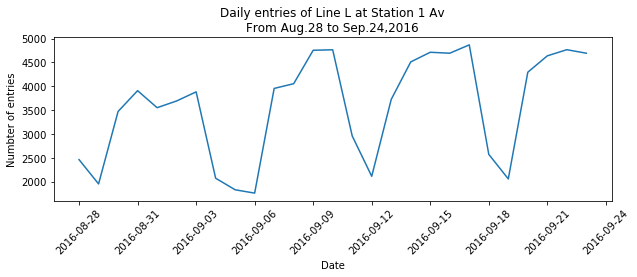

In [42]:
lists = dict_station['1 AV L']

date_vs=[]
for i in range(len(lists)):
    date_vs.append(parser.parse(lists[i][0]))

entry_vs=[]
for j in range(len(lists)):
    entry_vs.append(lists[j][1])
    
plt.figure(figsize=(10,3))
plt.plot(date_vs,entry_vs)
plt.title('Daily entries of Line L at Station 1 Av\n'
         'From Aug.28 to Sep.24,2016')
plt.xlabel('Date')
plt.ylabel('Numbter of entries')
plt.xticks(rotation=45)

In [45]:
gb_turnstilea_daily['DAY'] = gb_turnstilea_daily['DATE'].map(lambda day: parser.parse(day).weekday())
station_weekly_clean = gb_turnstilea_daily[gb_turnstilea_daily['DAILY_ENTRIES']<20000]

In [51]:
gb_turnstilea_daily[gb_turnstilea_daily['DAILY_ENTRIES']>20000]
# list outlier, and exclude them in sorting next cell.

,C/A,UNIT,STATION-LINE,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,DAY
4693,JFK01,R535,HOWARD BCH JFK A,09/13/2016,33,09/12/2016,24318.0,24285.0,1
4743,JFK03,R536,JFK JAMAICA CT1 E,09/07/2016,348,09/06/2016,61499.0,61151.0,2
8112,N206,R104,167 ST BD,09/16/2016,262144,09/15/2016,291.0,261853.0,4
8614,N303,R015,5 AV/53 ST EM,09/16/2016,12365978,09/15/2016,12311142.0,54836.0,4
8615,N303,R015,5 AV/53 ST EM,09/17/2016,12317869,09/16/2016,12365978.0,48109.0,5
8616,N303,R015,5 AV/53 ST EM,09/18/2016,12365990,09/17/2016,12317869.0,48121.0,6
12166,PTH09,R548,CHRISTOPHER ST 1,09/23/2016,670029,09/22/2016,149829.0,520200.0,4
12276,PTH13,R541,THIRTY ST 1,09/21/2016,1143,09/20/2016,22866.0,21723.0,2


## III. Get the top stations during required time series.

In [52]:
top_station_weekly = station_weekly_clean.groupby(['STATION-LINE']).DAILY_ENTRIES.sum().sort_values(ascending = False)
top_station_weekly.head(10)

STATION-LINE
GRD CNTRL-42 ST 4567S          332713.0
34 ST-HERALD SQ BDFMNQR        269748.0
42 ST-PORT AUTH ACENQRS1237    246581.0
TIMES SQ-42 ST 1237ACENQRS     217337.0
59 ST 456NQR                   190059.0
FULTON ST 2345ACJZ             187608.0
59 ST COLUMBUS ABCD1           186201.0
34 ST-PENN STA ACE             183070.0
14 ST-UNION SQ 456LNQR         160532.0
CANAL ST JNQRZ6                159802.0
Name: DAILY_ENTRIES, dtype: float64

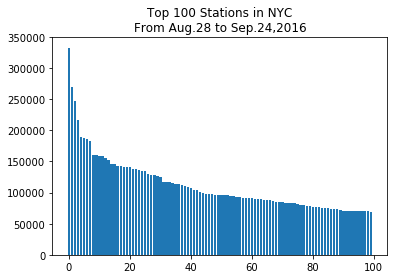

In [60]:
indices = range(len(top_station_weekly.head(100)))
plt.bar(indices, top_station_weekly.head(100))
# plt.xticks(indices,top_station_weekly.keys(),rotation='vertical')
plt.title('Top 100 Stations in NYC\n'
         'From Aug.28 to Sep.24,2016')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

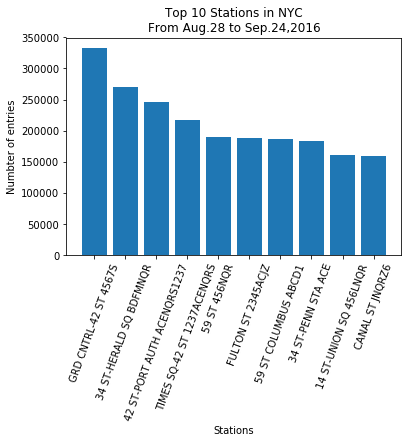

In [59]:
indices = range(len(top_station_weekly.head(10)))
plt.bar(indices, top_station_weekly.head(10))
plt.xticks(indices,top_station_weekly.keys(),rotation='vertical')
plt.title('Top 10 Stations in NYC\n'
         'From Aug.28 to Sep.24,2016')
plt.xlabel('Stations')
plt.ylabel('Numbter of entries')
plt.xticks(rotation=70)